**Задача**

Предсказать, отдаст ли заемщик кредит для датасета test.csv. 

Целевая метрика - F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

<img src="pic1.jpg" alt="Drawing" style="width: 500px;">

In [1]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
import lightgbm as lgbm
import catboost as catb

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

<div class="alert alert-block alert-info", align = 'center'>
    <b>Обзор данных</b>
</div>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Загрузка данных**

In [12]:
TRAIN_DATASET_PATH = '/Users/OzzyPeople/documents/GeekBrains/0_MLClassification/data/course_project_train.csv'
TEST_DATASET_PATH = '/Users/OzzyPeople/documents/GeekBrains/0_MLClassification/data/course_project_test.csv'

In [13]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [14]:
df_train.shape

(7500, 17)

In [15]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

**Обзор количественных признаков**

In [16]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Обзор номинативных признаков**

In [18]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

**Выделение целевой переменной и групп признаков**

In [19]:
TARGET_NAME = 'Credit Default'

**Обзор целевой переменной**

In [20]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

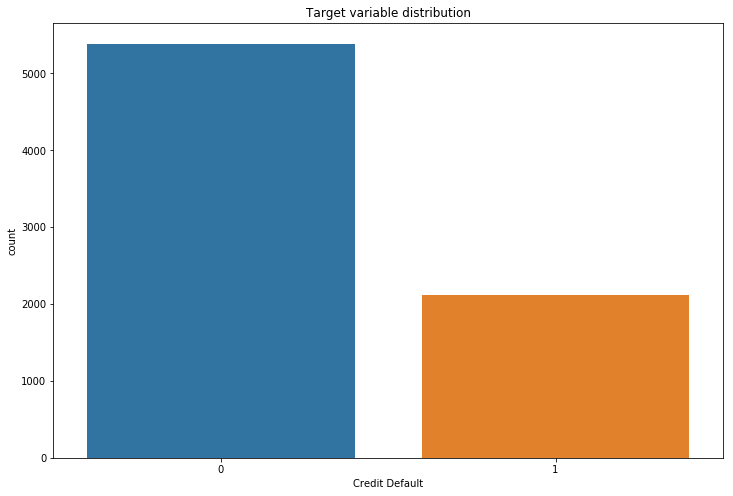

In [21]:
plt.figure(figsize=(12, 8))
sns.countplot(x=df_train[TARGET_NAME], data=df_train)
plt.title('Target variable distribution')
plt.show()

<div class="alert alert-block alert-info", align = 'center'>
    <b>Обработка пропусков</b>
</div>

In [22]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Обработка пропусков<a class="anchor" id="gaps"></a>

Замена Nan значение на среднее

In [23]:
def fill_mean(df, name_column:str):
    mean_val = df[name_column].mean()
    df[name_column] = df[name_column].fillna(mean_val)
    return df[name_column].isnull().sum()

In [24]:
fill_mean(df_train, 'Annual Income')
fill_mean(df_train, 'Months since last delinquent')
fill_mean(df_train, 'Credit Score')

0

In [25]:
#Заполним недостающие значения mode 
bankruptcies_mode = df_train['Bankruptcies'].mode().iloc[0] 
df_train['Bankruptcies']=df_train['Bankruptcies'].fillna(bankruptcies_mode)

<div class="alert alert-block alert-info", align = 'center'>
    <b>Создание новых признаков</b>
</div>

In [26]:
#Сделаем из категориального признака 'Years in current job' вещественный

vals_to_replace = {'< 1 year' : 0.5, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, \
                  '7 years' : 7, '8 years' : 8, '9 years' : 9 , '10+ years' : 10}  
def cat_to_num(df, dict_v:dict, name):
    df[name]= df[name].map(dict_v)
    return df[name].unique()

cat_to_num(df_train, vals_to_replace, 'Years in current job')

array([ nan, 10. ,  8. ,  6. ,  7. ,  5. ,  1. ,  0.5,  4. ,  3. ,  2. ,
        9. ])

In [27]:
fill_mean(df_train, 'Years in current job')

0

In [28]:
#Переведем признак 'Months since last delinquent' в категории 

bins=[-1,20,40,60,80,100, 120]
labels=['a','b','c','d', 'e', 'f']

#функция перевода в категориальный признак + создает дополнительный столбец с новым признаком в dataframe

def num_to_cat(df, name:str, bins:list, labels:list, pos:int, newname:str):
    category = pd.cut(df[name], bins=bins,labels=labels)
    df.insert(pos,newname,category)
    return df[newname].unique()

num_to_cat(df_train, 'Months since last delinquent', bins, labels, 5, 'months_d')

[b, d, a, c, e, f]
Categories (6, object): [a < b < c < d < e < f]

In [29]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
months_d                        0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

Финальный список признаков: вещественный и категориальный

In [30]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts',\
       'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', \
       'Number of Credit Problems', 'Credit Score']

In [31]:
#'Bankruptcies' - убрали, так как низкая корреляция в данных и модели стали только лучше
CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term',  'Tax Liens', 'months_d'] 

In [32]:
SELECTED_FEATURE_NAMES = CAT_FEATURE_NAMES + NUM_FEATURE_NAMES

<div class="alert alert-block alert-info", align = 'center'>
    <b>Обработка выбросов</b>
</div>

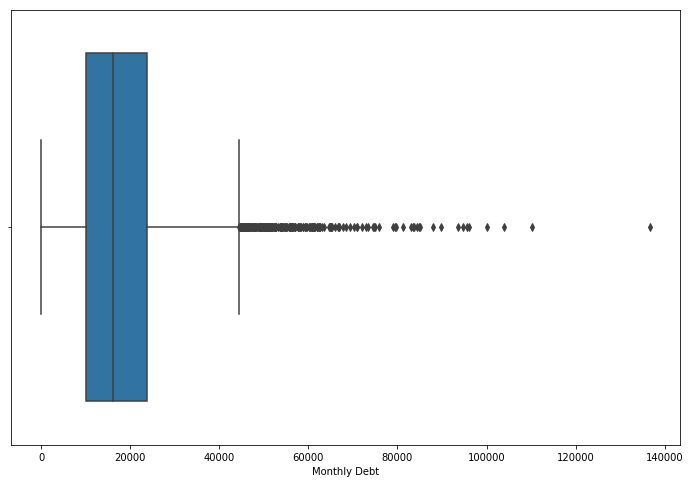

In [33]:
#Посмотрим в качестве пример на 'Monthly Debt'
plt.figure(figsize=(12, 8))
sns.boxplot(x=df_train['Monthly Debt'])

In [34]:
#Оценка отношения количества выбросов к общему количеству признака

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    num = (len(df_in)- len(df_out))/len(df_in)
    return num

Оценим выбросы по некатегориильным признакам, разбив признаки на категориальные и вещественные (непрерывные) 

In [35]:
for i in NUM_FEATURE_NAMES:
    print (f'% выбросов признака {i} = {remove_outlier(df_train, i)*100}')

% выбросов признака Annual Income = 6.88
% выбросов признака Years in current job = 0.0
% выбросов признака Years of Credit History = 3.04
% выбросов признака Number of Open Accounts = 3.0533333333333332
% выбросов признака Maximum Open Credit = 6.213333333333333
% выбросов признака Current Loan Amount = 11.600000000000001
% выбросов признака Current Credit Balance = 5.866666666666666
% выбросов признака Monthly Debt = 3.4000000000000004
% выбросов признака Number of Credit Problems = 100.0
% выбросов признака Credit Score = 5.333333333333334


Не будем ничего выкидывать

<div class="alert alert-block alert-info", align = 'center'>
    <b>Анализ данных</b>
</div>

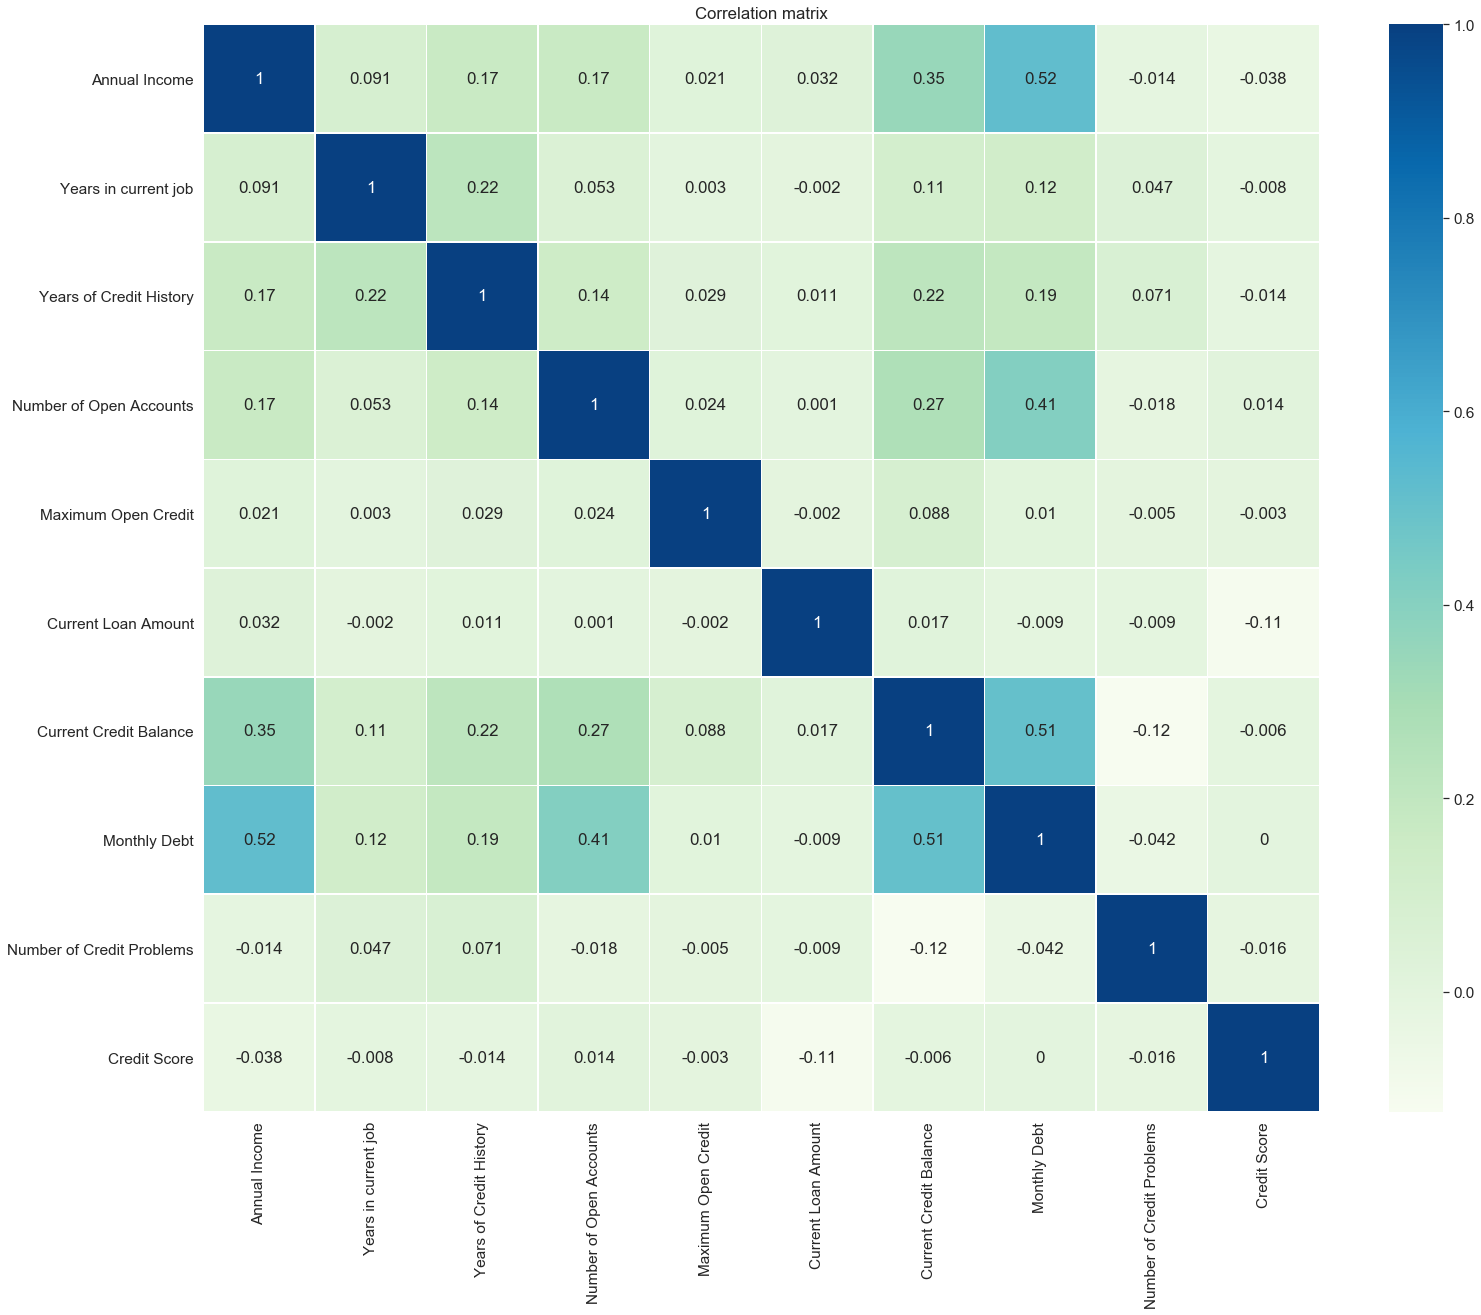

CPU times: user 1.21 s, sys: 156 ms, total: 1.36 s
Wall time: 1.56 s


In [36]:
%%time
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[NUM_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

нет высоких к-тов корреляции между признаками, поэтому не будем объединять признаки

**Корреляция с выбранными признаками и целевой переменной**

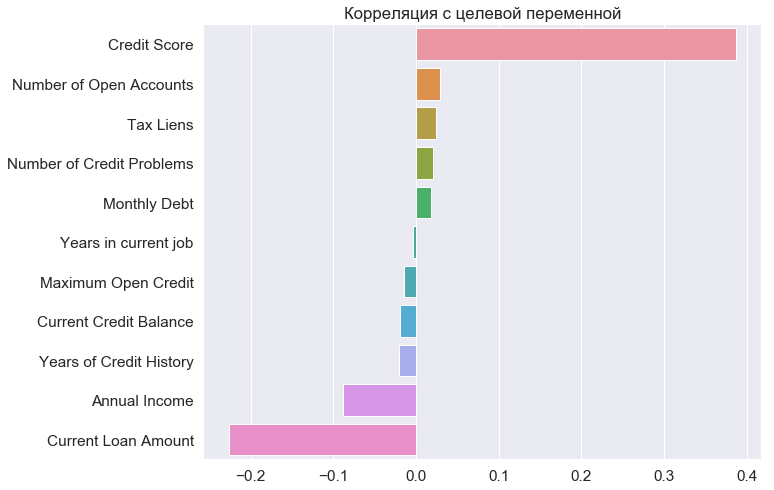

In [37]:
corr_with_target = df_train[SELECTED_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция с целевой переменной')
plt.show()

Два признака сильно выделяются "Credit Score" и 'Current Loan Amount'

<div class="alert alert-block alert-info", align = 'center'>
    <b>Отбор признаков</b>
</div>

Переводим в бинарные величины категориальный признаки

In [38]:
df = pd.get_dummies(df_train, columns = CAT_FEATURE_NAMES)

В результате анализа, в модель не включили, такие признаки, как Bankruptcies из-за низкой корреляции с целевой переменной

<div class="alert alert-block alert-info", align = 'center'>
    <b>Нормализация данных и разбиение выборки</b>
</div>

**Нормализация данных**

In [39]:
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

**Разбиение на train и test**

In [40]:
X = df.drop([TARGET_NAME], axis = 1)
y = df[TARGET_NAME]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

<div class="alert alert-block alert-info", align = 'center'>
    <b>Балансировка классов и целевой переменной</b>
</div>

In [42]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    #количество повторов минорного класса, которые необходимо сделать, чтобы сбалансировать обучение модели - вбыорку 
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1) 

In [43]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_for_balancing[TARGET_NAME].value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [44]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [45]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

<div class="alert alert-block alert-info", align = 'center'>
    <b>Построение и оценка базовой модели</b>
</div>

Был проведен анализ 5-и моделей, включая логистичесую регрессию, метод k ближайших соседей и бустинговые алгоритмы: XGBClassifier, LGBMClassifier и CatBoostClassifier. Самые высокие результаты показал **XGBClassifier**.

In [46]:
#Функция оценки качества 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Базовая модель XGBClassifier**

In [47]:
%%time
model_xgb = xgb.XGBClassifier(random_state=100)
model_xgb.fit(X_train, y_train)
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      3771
           1       0.78      0.58      0.66      2958

   micro avg       0.74      0.74      0.74      6729
   macro avg       0.75      0.73      0.73      6729
weighted avg       0.75      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.56      0.49      0.52       634

   micro avg       0.75      0.75      0.75      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                326  308
CPU times: user 2.13 s, sys: 41.6 ms, total: 2.17 s
Wall time: 1.97 s


<div class="alert alert-block alert-info", align = 'center'>
    <b>Подбор гиперпараметров модели</b>
</div>

Проверим, как количество деревьев влияет на качество результата

In [49]:
from sklearn.metrics import make_scorer

In [50]:
#Берем сразу от 50, так как ниже смысла нет, тренд идет от 0
n_trees = range(50,250, 5)

In [51]:
xgb_scoring = []
for n_tree in n_trees:
    estimator =  xgb.XGBClassifier(learning_rate=0.6, max_depth=3, n_estimators=n_tree, min_child_weight=3)
    score = cross_val_score(estimator, X_train, y_train, \
                            scoring=make_scorer(f1_score, average='weighted', labels=[1]), cv = 3)
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring )

Определим лучшее значение f1 по количеству деревьев

In [52]:
best_score_f1 = xgb_scoring.mean(axis = 1).max()
position_best_score = np.where(xgb_scoring.mean(axis = 1) == best_score_f1)[0][0]
list_n_trees = [x for x in n_trees]
best_number_of_trees = list_n_trees[position_best_score ]

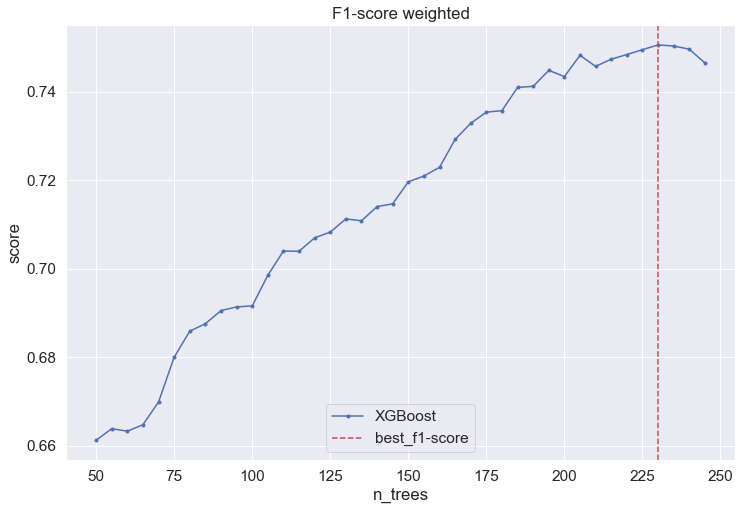

In [53]:
#Посмотрим на графике результаты

plt.figure(figsize=(12, 8))
plt.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label = 'XGBoost')
plt.axvline(x=best_number_of_trees, color='r', linestyle='--', label = 'best_f1-score' )
plt.grid(True)
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('F1-score weighted')
plt.legend(loc='lower center')
plt.show()

Определим лучшие значения max_depth и min_child_weight

In [55]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
estimator1 = xgb.XGBClassifier(learning_rate =0.6, n_estimators=best_number_of_trees, max_depth=5, min_child_weight=1)
gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=3) 
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.6,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=230, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [56]:
best_max_depth = gsearch1.best_params_['max_depth']
best_min_child_weight = gsearch1.best_params_['min_child_weight']
gsearch1.best_score_

0.7936589151239484

Настроим показатель gamma 

In [57]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
estimator2 = xgb.XGBClassifier(learning_rate =0.6, n_estimators=best_number_of_trees, max_depth=best_max_depth,\
                               min_child_weight=best_min_child_weight)
gsearch2 = GridSearchCV(estimator1, param_grid = param_test2, scoring='f1',n_jobs=4,iid=False, cv=3) 
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.6,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=230, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [58]:
best_gamma = gsearch2.best_params_['gamma']

In [59]:
gsearch2.best_score_

0.7921328649547473

In [ ]:
best_reg_alpha = gsearch3.best_params_['reg_alpha']

<div class="alert alert-block alert-info", align = 'center'>
    <b>Финальная модель, оценка качества</b>
</div>

По результатам подбора гиперпараметров, наша модель переобучилась, поэтому добавим показатели регуляризации reg_alpha =20 (L1), reg_lambda=50 (L2)

In [65]:
%%time
final_model = xgb.XGBClassifier(learning_rate = 0.6, max_depth = best_max_depth, \
                                n_estimators = best_number_of_trees, min_child_weight= best_min_child_weight,\
                                gamma = best_gamma, reg_alpha =20, reg_lambda=50)
final_model.fit(X_train, y_train)
y_train_pred_f = final_model.predict(X_train)
y_test_pred_f = final_model.predict(X_test)
get_classification_report(y_train, y_train_pred_f, y_test, y_test_pred_f)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      3771
           1       0.84      0.76      0.79      2958

   micro avg       0.83      0.83      0.83      6729
   macro avg       0.83      0.82      0.82      6729
weighted avg       0.83      0.83      0.83      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1616
           1       0.55      0.55      0.55       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1326  290
1                286  348
CPU times: user 4.1 s, sys: 30.4 ms, total: 4.13 s
Wall time: 3.89 s


<div class="alert alert-block alert-info", align = 'center'>
    <b>Подготовим тестовую выборку для Каggle</b>
</div>

In [66]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [67]:
fill_mean(df_test, 'Annual Income')
fill_mean(df_test, 'Months since last delinquent')
fill_mean(df_test, 'Credit Score')
cat_to_num(df_test, vals_to_replace, 'Years in current job')
bankruptcies_mode = df_test['Bankruptcies'].mode().iloc[0] 
df_test['Bankruptcies']=df_test['Bankruptcies'].fillna(bankruptcies_mode)
fill_mean(df_test, 'Years in current job')
num_to_cat(df_test, 'Months since last delinquent', bins, labels, 5, 'months_d')
df_test.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
months_d                        0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [68]:
df_test_ = pd.get_dummies(df_test, columns = CAT_FEATURE_NAMES)

**Нормализация данных**

In [69]:
scaler = StandardScaler()
df_norm_t = df_test_.copy()
df_norm_t[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm_t[NUM_FEATURE_NAMES])
df_test_ = df_norm_t.copy()

Сравнение тестового и тренировочного датасета

In [70]:
X_train.shape

(6729, 47)

In [71]:
df_test_.shape

(2500, 46)

Получаются разные размеры тестового и тренировочного датасета. Приведем их к единому размер по количеству столбцов

In [72]:
X_train_for_test = X_train

In [73]:
#Каких колонок не хватает в тесте из обучающей выборки?
missed_col_test = [x for x in df_test_.columns  if x not in X_train.columns]

#Каких колонок не хватает в обучающей выборки из теста?
missed_col_train = [x for x in X_train_for_test.columns if x not in df_test_.columns]

In [74]:
#Создадим дополнительные столбцы, которых не хватает и заполним нулями.
for i in missed_col_train:
    print (i)
    df_test_[i] = [0 for x in range (len(df_test_))]

Purpose_renewable energy
Tax Liens_7.0


In [75]:
for i in missed_col_test:
    X_train_for_test[i] = [0 for x in range (len(X_train))]

In [76]:
# Преобразуем в numpy array все выборки
X_train_for_test_1 = X_train_for_test.values
df_test_1 = df_test_.values

<div class="alert alert-block alert-success">
     <b>Предсказание, подготовка файла</b>
</div>

In [77]:
final_model_t = xgb.XGBClassifier(learning_rate = 0.6, max_depth = best_max_depth, \
                                n_estimators = 245, min_child_weight= best_min_child_weight,\
                                gamma = best_gamma, reg_alpha =40, reg_lambda=60)

In [78]:
final_model_t.fit(X_train_for_test_1, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.1,
       learning_rate=0.6, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=245, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=40, reg_lambda=60, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [79]:
prediction = final_model_t.predict(df_test_1)

**Submission file**

In [80]:
id_sub = [x for x in range (7500, 10000)]
dataset = pd.DataFrame({'Id': id_sub, 'Credit Default': prediction})

In [81]:
dataset.to_csv("submission.csv", index=False)

<img src="kaggle_r.png" alt="Drawing" style="width: 800px;">

<div class="alert alert-block alert-info", align = 'center'>
    <b>Резюме</b>
</div>

**Резюме**

При отборе признаков и разработке модели:

1. Перевели один категориальный признак в вещественный
2. Создали из вещественного один категориальный
3. Выкинули один некоррелириующий признак 
4. Выбрали модель и увеличили качество при помощи гиперпараметров на тесте с 0,52 до 0,55
5. Переобучились и воспользовались регуляризацией L1 и L2 

Хотя текущий результат не отличается более, чем на 8% от лучших на Kaggle, его можно улучшить в первую очередь за счет подготовки новых признаков, сокращения текущих признаков или упрощения модели.